In [68]:
from ipywidgets import interact
from fastai.basics import *
import numpy as np
from functools import partial
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [2]:
plt.rc('figure', dpi=90)

In [11]:
def functionPlot(f, title=None, min=-4.1, max=4.1, color='r', ylim=None):
    x = torch.linspace(min, max, steps=40)
    y = f(x)
    if ylim:
        plt.ylim(ylim)
    plt.plot(x,y, color)
    if title is not None: plt.title(title)

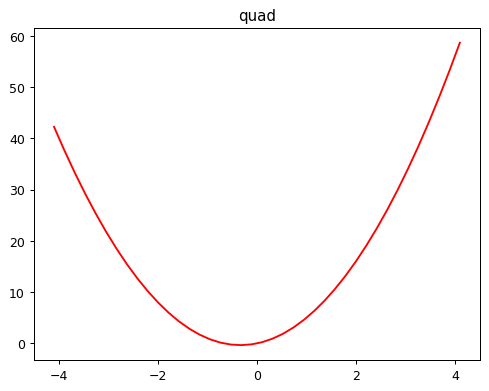

In [12]:
def f(x):
    return 3*x**2 + 2*x

functionPlot(f, title='quad')

In [13]:
def quad(a,b,c,x):
    return (a*x**2 + b*x + c)

def makeQuad(a,b,c):
    return partial(quad, a, b, c)

In [14]:
f = makeQuad(3,2,1)
f

functools.partial(<function quad at 0x16c269a80>, 3, 2, 1)

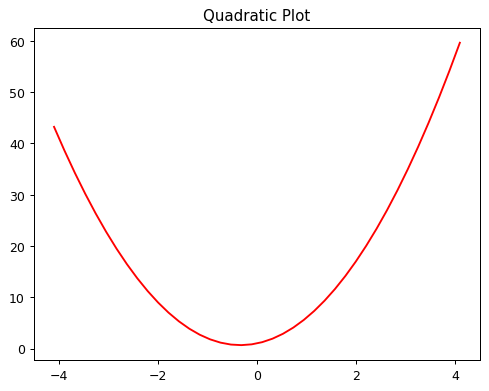

In [15]:
functionPlot(f, "Quadratic Plot")

In [16]:
"""
Adding Noise to the 'x' coordinates, because we don't know which quadratic they'll be a part of,
then calculating the 'y' coordinates for those.
This would return points that are scattered around and not perfect on quadratic graph , like real data
"""

def noise(scale, x): return np.random.normal(scale=scale, size=x.shape)

In [18]:
test_data=np.array([3,6,1,2,0,9])
noise(scale=1.2, x=test_data)

array([ 1.20274154,  1.50930213, -1.65187103,  0.91007098, -0.46772772,
        1.3798729 ])

In [24]:
"""
Adding the above generated noise to the data points
"""

def addNoise(x, mult_scale, add_scale):
    return x*(1+noise(scale=mult_scale, x=x)) + (noise(scale=add_scale, x=x))

In [25]:
addNoise(mult_scale=0.5, add_scale=1, x=test_data)

array([ 0.20324346, 10.95652148,  0.66432887,  2.00916142, -0.04631402,
        9.34538013])

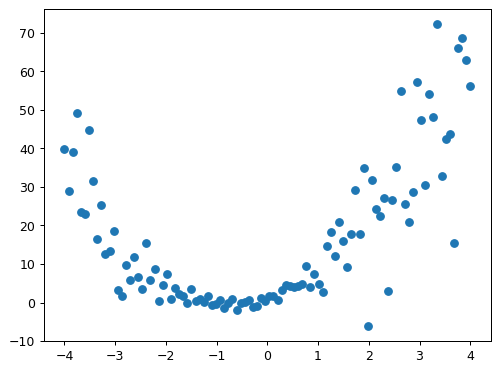

In [111]:
np.random.seed(42)

x = torch.linspace(start=-4, end=4, steps=100)#[:,None]
y = addNoise(x=quad(3,4,1,x=x), mult_scale=0.5, add_scale=1)

plt.scatter(x,y)

In [117]:
# def meanSquareError(acts, preds):
#     squared_errors=(acts-preds)**2
#     mean_squared_error = np.sum(np.array(squared_errors))/len(acts)
#     return mean_squared_error, squared_errors


def meanSquareErrorTorch(acts, preds):
    # acts, preds are torch tensors with requires_grad
    squared_errors = (acts - preds)**2
    mean_squared_error = torch.mean(squared_errors)  # Use torch.mean, not NumPy, so that gradients are kept in computations graph later
    return mean_squared_error, squared_errors


@interact(a=1.1, b=1.1, c=1.1)
def plotQuad(a,b,c):
    plt.scatter(x,y)
    mean_erros, point_errors=meanSquareError(y, makeQuad(a,b,c)(x=x))

    functionPlot(makeQuad(a,b,c), ylim=(-10,100), title=mean_erros)

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [121]:
# def quad_mae(params):
#     f = makeQuad(*params)
#     mean_error, point_error = meanSquareError(f(x).detach(), y.detach())
#     return point_error

def quad_mae(params):
    f = makeQuad(*params)
    mean_error, point_error = meanSquareErrorTorch(f(x), y)  # <-- no detach
    return mean_error  # return the mean loss for backward



"""
But squared_errors is a tensor with requires_grad=True (because it depends on abc, which has requires_grad_()).

PyTorch blocks converting such tensors directly to NumPy (.numpy()), because that would break the computation graph for autograd.

You can detach before calling your function, so that inside meanSquareError NumPy is happy:

.detach() tells PyTorch:
“Give me a copy of this tensor’s data, but stop tracking it for gradients.”

That way you can safely convert to NumPy inside your function.
"""

'\nBut squared_errors is a tensor with requires_grad=True (because it depends on abc, which has requires_grad_()).\n\nPyTorch blocks converting such tensors directly to NumPy (.numpy()), because that would break the computation graph for autograd.\n\nYou can detach before calling your function, so that inside meanSquareError NumPy is happy:\n\n.detach() tells PyTorch:\n“Give me a copy of this tensor’s data, but stop tracking it for gradients.”\n\nThat way you can safely convert to NumPy inside your function.\n'

In [122]:
abc = torch.tensor([1.1, 1.1, 1.1])
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

In [123]:
point_error = quad_mae(abc)
point_error

tensor(298.3671, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [124]:
point_error.backward()

In [125]:
abc.grad

tensor([-196.8523,  -27.3227,  -19.9106])

In [ ]:
"""
✅ Key points:

Never convert tensors to NumPy if you want to backpropagate.

Use PyTorch operations for all computations that require gradients.

Only .detach() tensors if you explicitly want to stop gradients.
"""